### 1. Analyze the Data

#### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

In [2]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

#### Data Preprocessing

In [3]:
company = 'MSFT'

In [4]:
start = dt.datetime(2010,1,1)
end = dt.datetime(2022,4,1)

In [5]:
data = web.DataReader(company, 'yahoo', start, end)

In [6]:
data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2009-12-31,30.990000,30.480000,30.980000,30.480000,31929700.0,23.438797
2010-01-04,31.100000,30.590000,30.620001,30.950001,38409100.0,23.800224
2010-01-05,31.100000,30.639999,30.850000,30.959999,49749600.0,23.807915
2010-01-06,31.080000,30.520000,30.879999,30.770000,58182400.0,23.661812
2010-01-07,30.700001,30.190001,30.629999,30.450001,50559700.0,23.415731
...,...,...,...,...,...,...
2022-03-28,310.799988,304.329987,304.329987,310.700012,29578200.0,309.978058
2022-03-29,315.820007,309.049988,313.910004,315.410004,30393400.0,314.677094
2022-03-30,315.950012,311.579987,313.760010,313.859985,28163600.0,313.130676


#### Split the dataset

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [8]:
prediction_days = 60

In [9]:
x_train = []
y_train = []

In [10]:
for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

In [11]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

### 2. Train the model

In [12]:
model = Sequential()

In [14]:
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) #Predicting the next close

In [15]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [16]:
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
95/95 [==============================] - 13s 72ms/step - loss: 0.0060
Epoch 2/25
95/95 [==============================] - 7s 72ms/step - loss: 0.0014
Epoch 3/25
95/95 [==============================] - 7s 71ms/step - loss: 0.0013
Epoch 4/25
95/95 [==============================] - 7s 70ms/step - loss: 0.0012
Epoch 5/25
95/95 [==============================] - 7s 69ms/step - loss: 0.0011
Epoch 6/25
95/95 [==============================] - 7s 72ms/step - loss: 0.0012
Epoch 7/25
95/95 [==============================] - 7s 70ms/step - loss: 0.0011
Epoch 8/25
95/95 [==============================] - 7s 70ms/step - loss: 0.0011
Epoch 9/25
95/95 [==============================] - 7s 71ms/step - loss: 0.0011
Epoch 10/25
95/95 [==============================] - 7s 69ms/step - loss: 9.0212e-04
Epoch 11/25
95/95 [==============================] - 7s 71ms/step - loss: 9.6638e-04
Epoch 12/25
95/95 [==============================] - 7s 70ms/step - loss: 8.4288e-04
Epoch 13/25
95/95 [=====

### 3. Test the model

In [18]:
test_start = dt.datetime(2022,4,1)
test_end = dt.datetime.now()

In [19]:
test_data = web.DataReader(company, 'yahoo', test_start, test_end)

In [20]:
test_data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-03-31,315.140015,307.890015,313.899994,308.309998,33422100.0,307.593567
2022-04-01,310.130005,305.540009,309.369995,309.420013,27110500.0,308.701019
2022-04-04,315.109985,309.709991,310.089996,314.970001,24289600.0,314.238098
2022-04-05,314.869995,309.869995,313.269989,310.880005,23156700.0,310.157623
2022-04-06,307.000000,296.709991,305.190002,299.500000,40110400.0,298.804047


In [21]:
actual_prices = test_data['Close'].values

In [22]:
total_dataset = pd.concat((data['Close'], test_data['Close']), axis =0)

In [23]:
model_inputs = total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

##### Make predictions

In [24]:
x_test = []

In [25]:
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

In [26]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [27]:
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

#### 5. Visualization

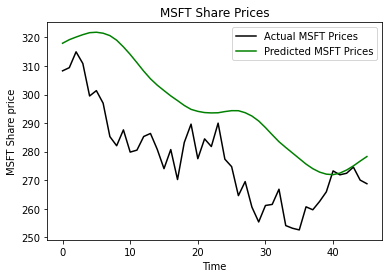

In [28]:
plt.plot(actual_prices, color="black", label=f"Actual {company} Prices")
plt.plot(predicted_prices, color='green', label=f"Predicted {company} Prices")
plt.title(f"{company} Share Prices")
plt.xlabel('Time')
plt.ylabel(f'{company} Share price')
plt.legend()
plt.show()